In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300

# Getting started

For this tutorial, we're going to fit a Gaussian Process (GP) model to a simulated dataset with quasiperiodic oscillations. We're also going to leave a gap in the simulated data and we'll use the GP model to predict what we would have observed for those "missing" datapoints.

To start, here's some code to simulate the dataset:

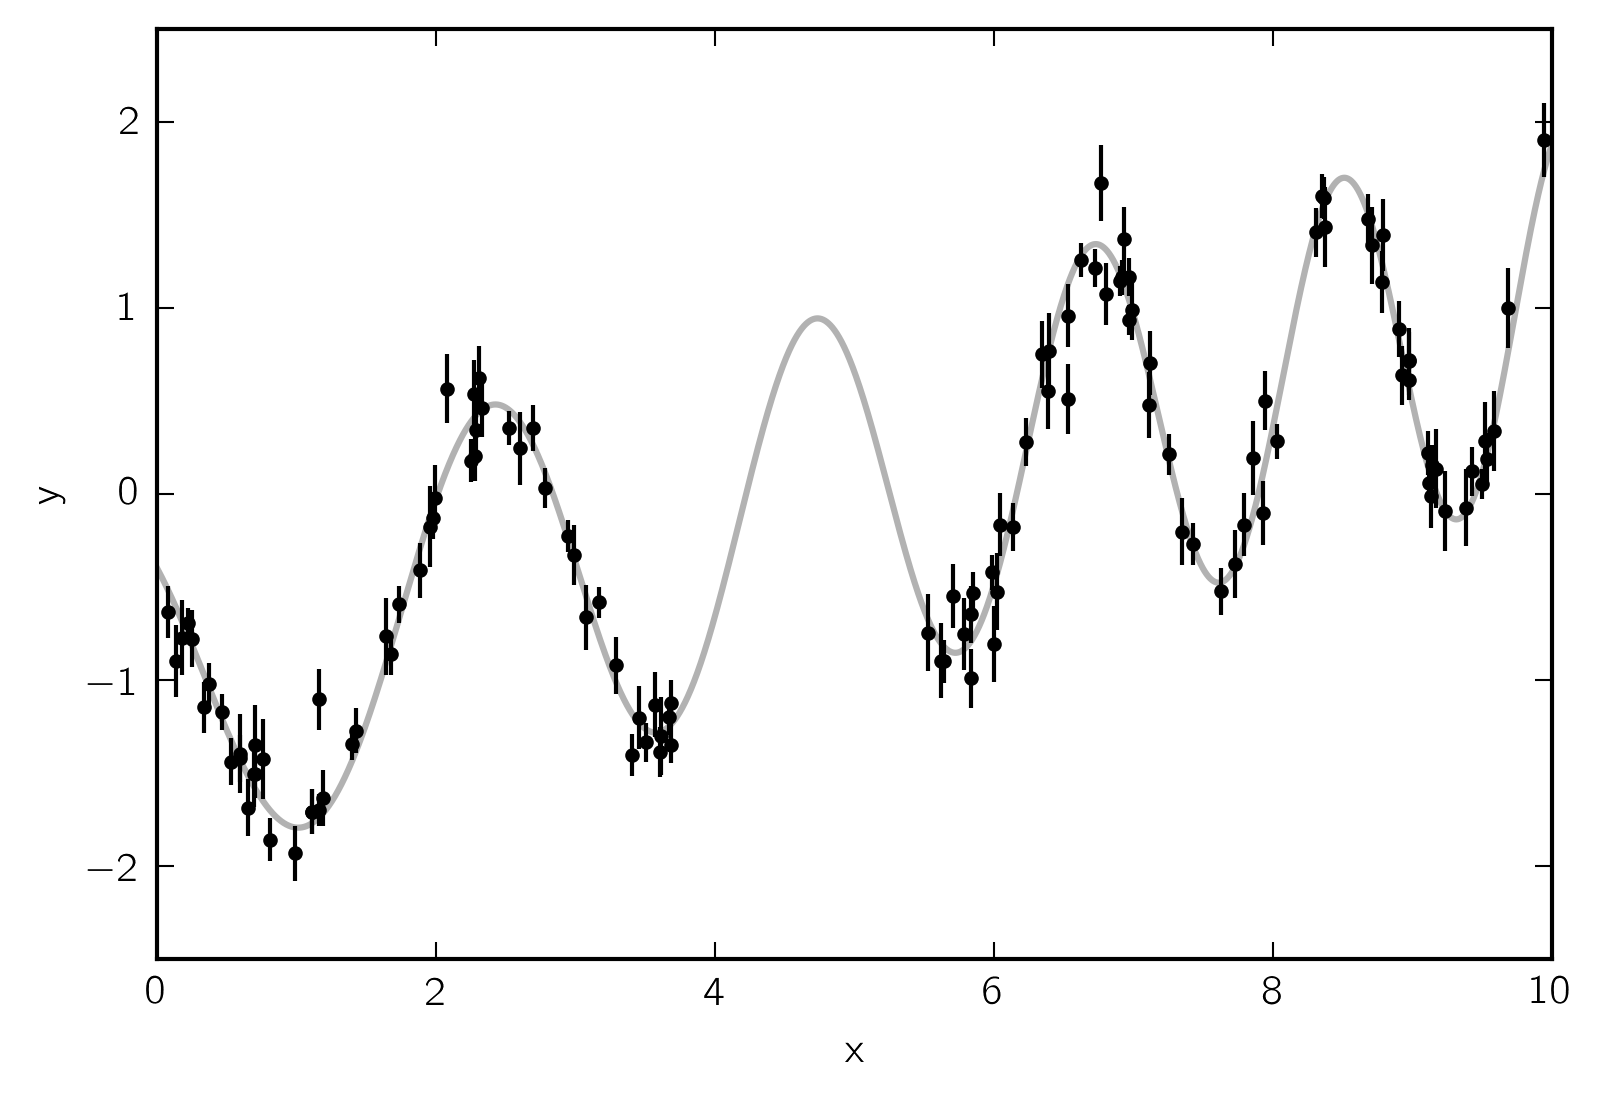

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

This plot shows the simulated data as black points with error bars and the true function is shown as a gray line.

Now let's build the `celerite` model that we'll use to fit the data. We can see that there's some roughly periodic signal in the data as well as a longer term trend. To capture these two features, we will model this as a mixture of two stochastically driven simple harmonic oscillators with the power spectrum:

$$
S(\omega) = \sqrt{\frac{2}{\pi}}\frac{S_1\,{\omega_1}^4}{(\omega^2 - {\omega_1}^2)^2 + 2\,{\omega_1}^2\,\omega^2}
+ \sqrt{\frac{2}{\pi}}\frac{S_2\,{\omega_2}^4}{(\omega^2 - {\omega_2}^2)^2 + {\omega_2}^2\,\omega^2/Q^2}
$$

This model has 5 free parameters ($S_1$, $\omega_1$, $S_2$, $\omega_2$, and $Q$) and they must all be positive. In `celerite`, this is how you would build this model, choosing more or less arbitrary initial values for the parameters.

In [3]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel = terms.SHOTerm(np.log(S0), np.log(Q), np.log(w0),
                       bounds=[(-15, 15), (-15, 15), (-15, 15)])
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(np.log(S0), np.log(Q), np.log(w0),
                        bounds=[(-15, 15), (-15, 15), (-15, 15)])

Then we wrap this kernel in a `GP` object that can be used for computing the likelihood function.

In [4]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -6.756596382629667


There is a modeling language built into `celerite` that will come in handy. Other tutorials will go into more detail but here are some of the features that the modeling language exposes:

In [5]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:term[0]:log_S0', -0.84977866562586946), ('kernel:term[0]:log_omega0', 1.0986122886681098), ('kernel:term[1]:log_S0', -1.1963522559058422), ('kernel:term[1]:log_Q', 0.0), ('kernel:term[1]:log_omega0', 1.0986122886681098)])

parameter_names:
('kernel:term[0]:log_S0', 'kernel:term[0]:log_omega0', 'kernel:term[1]:log_S0', 'kernel:term[1]:log_Q', 'kernel:term[1]:log_omega0')

parameter_vector:
[-0.84977867  1.09861229 -1.19635226  0.          1.09861229]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (-15, 15), (-15, 15)]



You already saw that it is possible to freeze and thaw parameters above but here's what you would do if you wanted to freeze another parameter:

In [6]:
print(gp.get_parameter_names())
gp.freeze_parameter("kernel:term[0]:log_omega0")
print(gp.get_parameter_names())
gp.thaw_parameter("kernel:term[0]:log_omega0")
print(gp.get_parameter_names())

('kernel:term[0]:log_S0', 'kernel:term[0]:log_omega0', 'kernel:term[1]:log_S0', 'kernel:term[1]:log_Q', 'kernel:term[1]:log_omega0')
('kernel:term[0]:log_S0', 'kernel:term[1]:log_S0', 'kernel:term[1]:log_Q', 'kernel:term[1]:log_omega0')
('kernel:term[0]:log_S0', 'kernel:term[0]:log_omega0', 'kernel:term[1]:log_S0', 'kernel:term[1]:log_Q', 'kernel:term[1]:log_omega0')


Now we'll use the `L-BFGS-B` non-linear optimization routine from `scipy.optimize` to find the maximum likelihood parameters for this model.

In [7]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -16.563201710953706
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.40012479e-05,  -3.41060513e-05,   8.52651283e-06,
        -3.97903932e-05,  -8.52651283e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 29
   status: 0
  success: True
        x: array([ 3.27779101, -2.02446512, -4.16135219,  2.3418465 ,  1.13554489])


With a small dataset like this, this optimization should have only taken a fraction of a second to converge. The maximum likelihood parameters are the following:

In [8]:
gp.get_parameter_dict()

OrderedDict([('kernel:term[0]:log_S0', 3.2777910101071543),
             ('kernel:term[0]:log_omega0', -2.0244651244791885),
             ('kernel:term[1]:log_S0', -4.1613521854851117),
             ('kernel:term[1]:log_Q', 2.3418464959702914),
             ('kernel:term[1]:log_omega0', 1.1355448911625967)])

Finally, let's see what the model predicts for the underlying function. A GP model can predict the (Gaussian) conditional (on the observed data) distribution for new observations. Let's do that on a fine grid:

In [9]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Let's plot this prediction and compare it to the true underlying function.

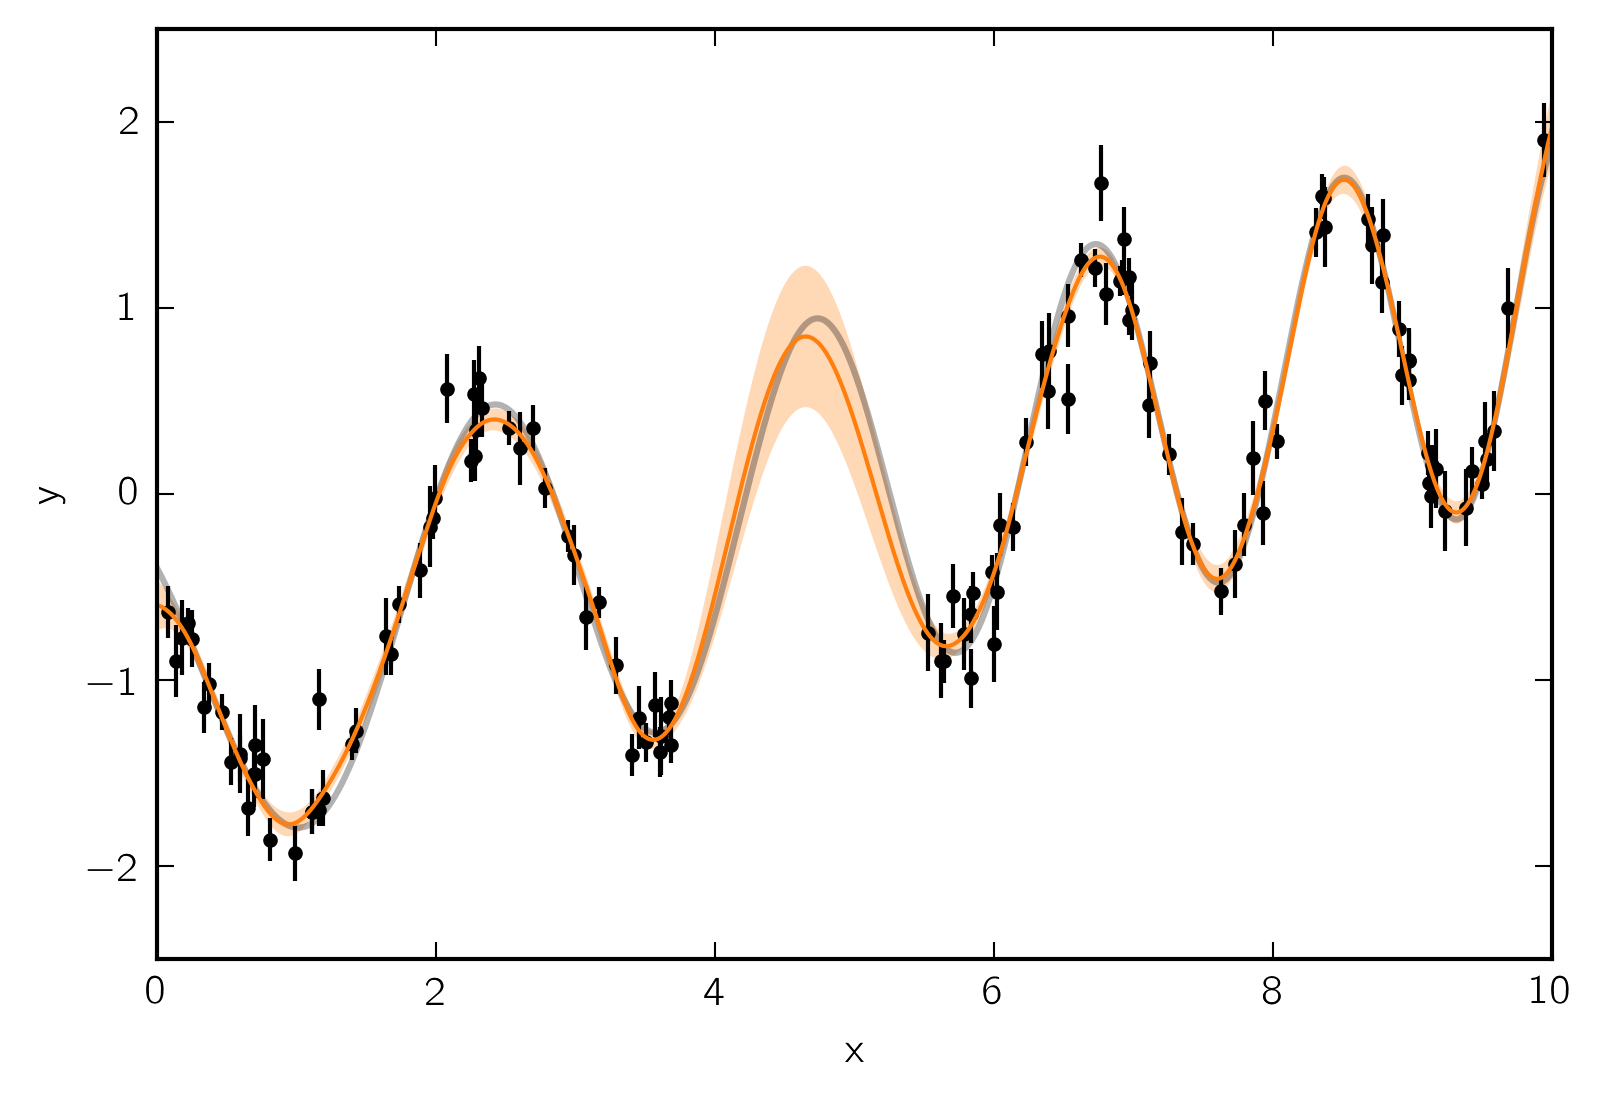

In [11]:
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In this figure, the 1-sigma prediction is shown as an orange band and the mean prediction is indicated by a solid orange line. Comparing this to the true underlying function (shown as a gray line), we see that the prediction is consistent with the truth at all times and the the uncertainty in the region of missing data increases as expected.

As the last figure, let's look at the maximum likelihood power spectrum of the model. The following figure shows the model power spectrum as a solid line and the dashed lines show the contributions from the two components.

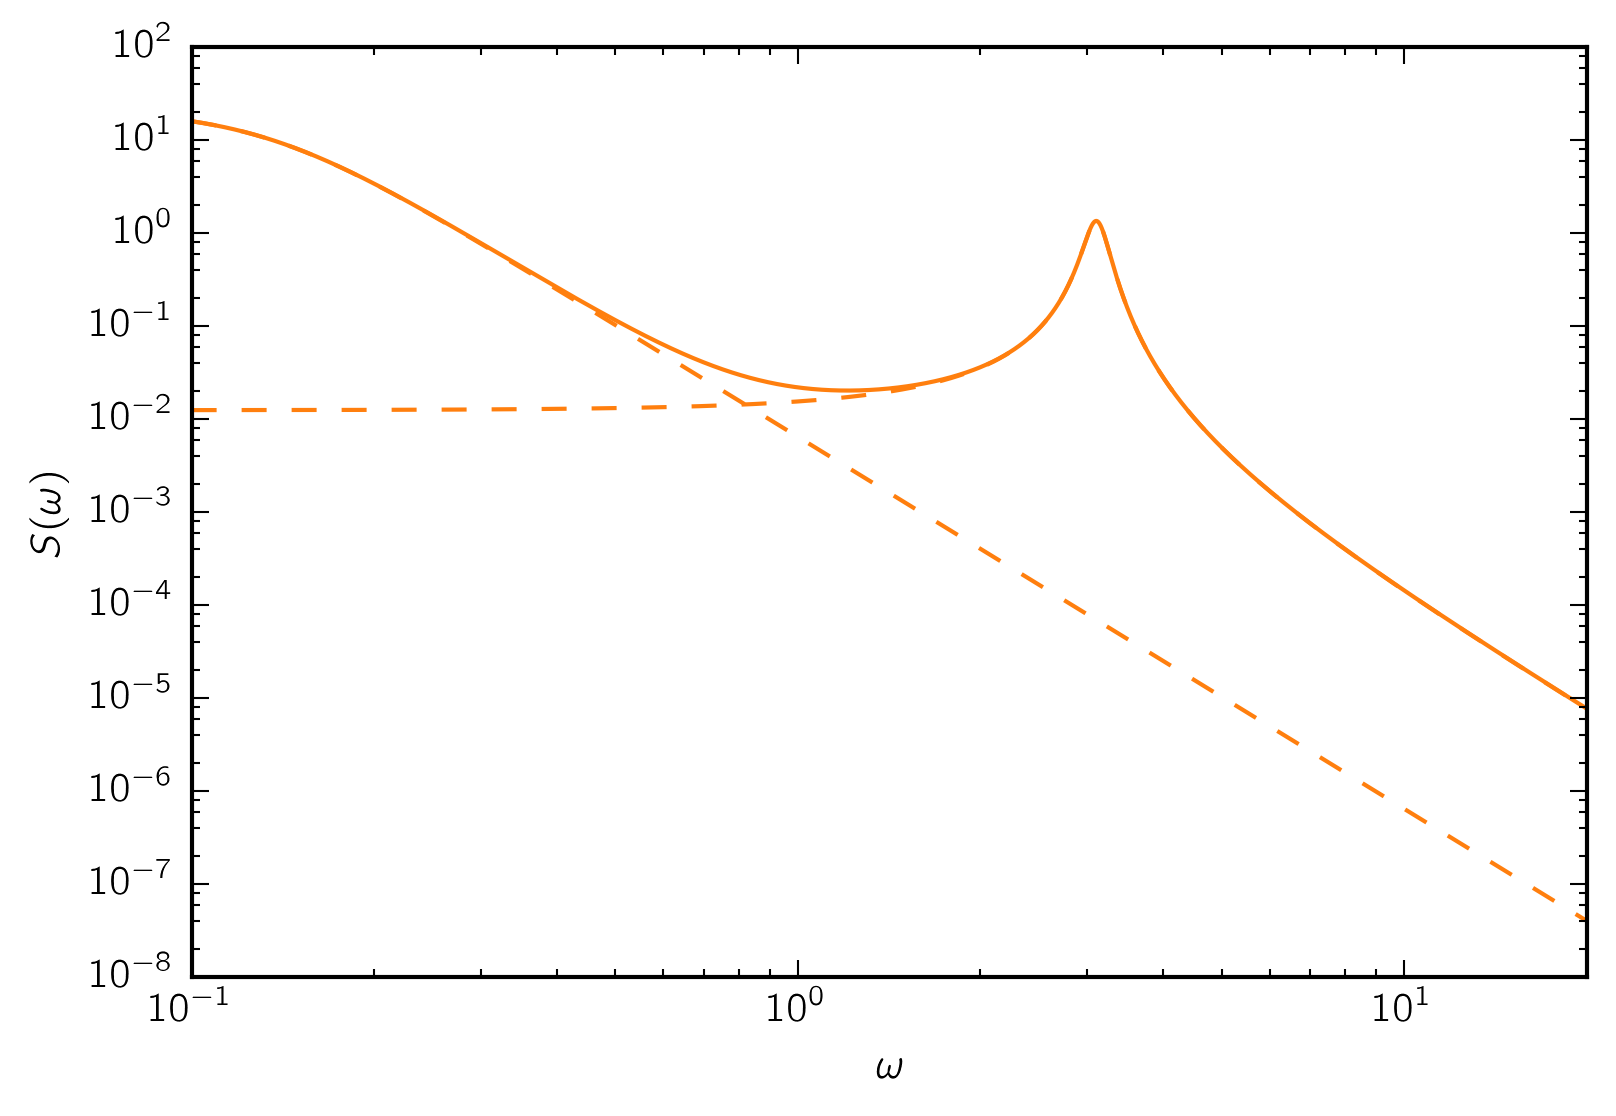

In [13]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");